# Enrichment Analyses of GATA1-/- Mouse Spleen
Enrichment analysis performed for Ilaria Ceglia by Anders Dohlman at Ma'ayan Lab 

_Icahn School of Medicine at Mount Sinai_; _Department of Pharmacology and Systems Therapeutics_; _BD2K-LINCS Data Coordination and Integration Center_; _One Gustave L. Levy Place, Box 1603, New York, NY 10029 USA_

## Introduction
Here we describe the results of microarray enrichment analysis of GATA1 knockout in PMF mice. The GATA1 transcription factor is a regulator of hematopoeisis and erythroid development, and its activation targets include in HBB, HBG1/2, ALS2, and HMBS. In previous studies by [_Zingariello et al_](http://www.ncbi.nlm.nih.gov/pubmed/23462118), GATA1-low myelofibrotic mice have were shown to have abnormal TGF-beta signaling, characterized by increased apoptosis and G1 arrest.

## Methods
We received microarray data from Ceglia containing spleen samples taken from three controls and three GATA1-knockouts to profile changes in gene expression. The six spleen samples were taken from mice were run on an Illumina microarray chip and processed by the Genomics Core Facility at Mount Sinai, where the data were quantile-normalized and reported in "FinalReport.txt". The data beneath the "Sample Gene Profile" header in the report was extracted and saved to [GATA1_spleen_profile.txt](https://github.com/abdohlman/GATA1-Analysis/blob/master/gata1_gene_profile.txt).

### Data preparation
* First, 30,854 gene profiles were extracted from "FinalReport-spleen.txt".
* We selected the "AVG_Signal" column for each of 6 samples:
    * **Controls**: cd1, cd2, cd3
    * **Knockouts**: gat1, gat2, gat3
3. The 30854 x 6 matrix was saved as "GATA1_spleen_profile.txt".

In [1]:
# Load dependencies
%matplotlib inline
import matplotlib
import json
import time
import requests
import os.path
import pandas as pd
import numpy as np
from sklearn import decomposition
from scipy.stats import zscore
import matplotlib.pyplot as plt
from IPython.display import display, HTML, Image

# Load data
df = pd.read_table('GATA1_spleen_profile.txt',sep='\t',index_col=0)
genelist = df.index.values
samples = df.columns.values

### Quality Control
After observing that negative signals corresponded to low confidence values, we mapped all negative values to zero. A negative value means less fluorescent than the control, ie. no signal is present. Next, we checked the microarray expression distributions using a log-normalized histogram for each sample.

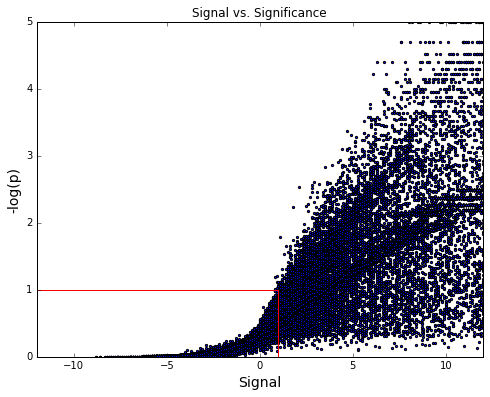

In [2]:
pvals = df[['cd1.Detection Pval','cd2.Detection Pval','cd3.Detection Pval',
            'gat1.Detection Pval','gat2.Detection Pval','gat3.Detection Pval']]
signal = df[['cd1.AVG_Signal','cd2.AVG_Signal','cd3.AVG_Signal',
             'gat1.AVG_Signal','gat2.AVG_Signal','gat3.AVG_Signal']]

fig = plt.figure(figsize=(8, 6), dpi=80)
x = list(pd.melt(signal)['value'])
y = list(pd.melt(-np.log10(pvals))['value'])
plt.axis([-12, 12, 0, 5])
plt.scatter(x,y,s=5)
plt.xlabel('Signal',fontsize=14)
plt.ylabel('-log(p)',fontsize=14)
plt.title('Signal vs. Significance')
plt.plot([-12,1],[1,1],'r-'); plt.plot([1,1],[0,1],'r-')
plt.show()

In [3]:
# Replace all negative values with zero
pd.options.mode.chained_assignment = None  # default='warn'
signal[signal < 0] = 0

signal.to_csv('GATA_spleen_zeroed.txt',sep='\t')

df = signal
samples = [x.split('.')[0] for x in df.columns.values]
df.columns = samples

print "Old matrix:",signal.shape
print "New matrix:",df.shape

Old matrix: (30853, 6)
New matrix: (30853, 6)


Now we check the log-distribution of gene expression values in each sample.

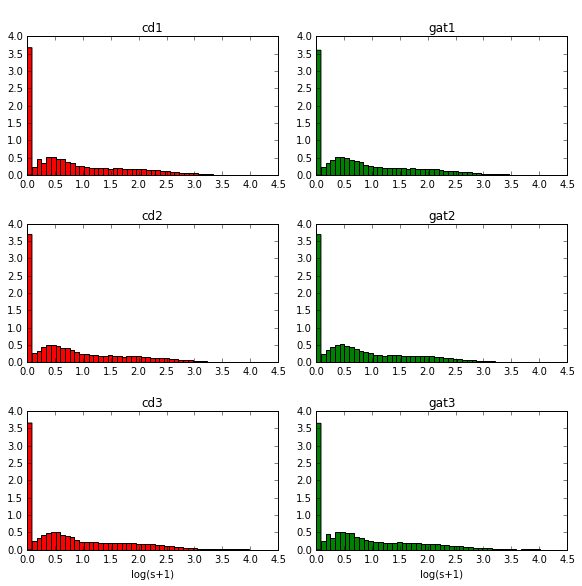

In [4]:
# Log transform
logDf = np.log10(df+1)

fig = plt.figure(figsize=(8, 8), dpi=80)

# Plot histograms of data
for i in range(1,7):
    fig.add_subplot(3,2,i)
    if i%2 == 0: s,col = 'gat' + str(i/2), 'green'
    else: s,col = 'cd' + str((i+1)/2), 'red'
    n, bins, patches = plt.hist(logDf[s], 50, normed=1, facecolor=col, alpha=1)
    plt.title('\n'+s)
    if int(s[-1]) == 3: plt.xlabel('log(s+1)')
plt.tight_layout(pad=0.4, w_pad=1.0, h_pad=0.8)

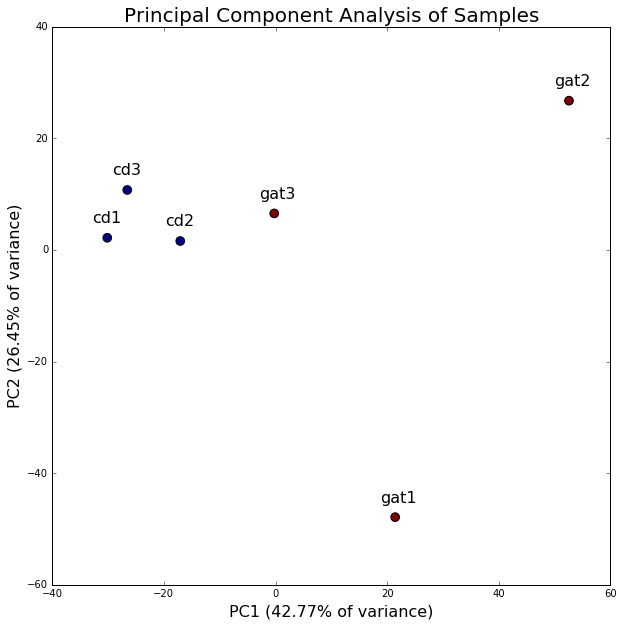

In [5]:
# Choose 2000 genes with greatest variance and zscore them
mat = df.transpose().as_matrix()
featvars = list(np.var(mat,axis=0))
select = np.argsort(featvars)[-2000:] 
mat = zscore(mat[:,select])

# Compute PCA Coordinates and Variance
pca = decomposition.PCA(n_components=None)
pca.fit(mat)
variance_explained = pca.explained_variance_ratio_[0:2] * 100
pca_coords = pca.transform(mat)[:, 0:2]
pca1, pca2 = zip(*pca_coords)

# Plot Results
fig = plt.figure(figsize=(10, 10), dpi=80)
plt.scatter(pca1,pca2,s=75,c=[1,1,1,2,2,2])
labels = ['PC%s (%.2f' % (i,pct) + '%' + ' of variance)'
          for i,pct in enumerate(variance_explained, start=1)]
for label, x, y in zip(samples,pca1,pca2):
    plt.annotate(label,xy=(x,y),xytext = (-15, 15), textcoords = 'offset points', fontsize=16)
plt.xlabel(labels[0],fontsize=16)
plt.ylabel(labels[1],fontsize=16)
# plt.axis([-60, 50, -60, 60])
plt.title("Principal Component Analysis of Samples",fontsize=20)
plt.show()

The clear separation between samples suggests they are a strong candidate for a robust differential expression signature.

### Processing the GATA1-/-  data into CD signatures
The Characteristic Direction (CD) method was used to compute differentially expressed genes. It computes the unit vector perpendicular the linear discriminant hyperplane separating control and sample conditions. An in-depth description of this method was published to [_BMC Bioinformatics_](http://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-15-79) in 2014. The python implementation used here can be found in the [_Ma'ayan Lab Github Repository_](https://github.com/MaayanLab/chdir/blob/master/chdir.py).

In [6]:
from chdir import chdir

ctrData = df[['cd1','cd2','cd3']].values
expData = df[['gat1','gat2','gat3']].values

def save_gene_lists(cdGenes,cdVector,n=500):
    geneOrder = [cdGenes[x] for x in np.argsort(cdVector)]
    geneValues = [cdVector[x] for x in np.argsort(cdVector)]
    genelist = {}
    fuzzylist = {}
    for dirn in ['up','dn']:
        if dirn == 'up':
            genelist = geneOrder[-n:]
            fuzzylist = map(lambda x,y: x+','+str(y), genelist, geneValues[-n:])
        else:
            genelist = geneOrder[:n]
            fuzzylist = map(lambda x,y: x+','+str(y), genelist, geneValues[:n])
    
        with open('GATA1_spleen_'+dirn+'Genes.txt','w') as f: f.write('\n'.join(genelist))
        with open('GATA1_spleen_'+dirn+'Genes_fuzzy.txt','w') as f: f.write('\n'.join(fuzzylist))          
    

# Get the charactersitic direction signature
[cdGenes,cdVector] = chdir(ctrData,expData,genelist)
save_gene_lists(cdGenes,cdVector)

df = pd.Series(cdVector, index=cdGenes, name='BMC')
df.to_csv('GATA1_spleen_cdVector.txt',sep='\t')

Calculating the characteristic direction.
Done chdir


In [7]:
# Libraries to use:
libraries = ['MGI_Mammalian_Phenotype_Level_4','WikiPathways_2015',
             'ChEA_2015','PPI_Hub_Proteins','ENCODE_TF_ChIP-seq_2015']

# Use this function to call the Enrichr API:
ENRICHR_URL = 'http://amp.pharm.mssm.edu/Enrichr/enrich'
def fetch_enrichr_results(genes, description=''):
    """Returns a dict which maps Enrichr libraries to enrichment results."""
    session = requests.session()
    payload = {'list': (None, genes), 'description': (None, description)}
    session.post(ENRICHR_URL, files=payload)
    results = {}
    for library in libraries:
        get_url = ENRICHR_URL + '?backgroundType=%s' % library
        response = session.get(get_url)
        print [str(x) for x in json.loads(response.text).keys()]
        if response.ok:
            results[library] = json.loads(response.text)[library]
        else: print "Error"
    return results

In [8]:
# Fetch gene lists
with open('GATA1_spleen_upGenes.txt') as f: upGenes = f.read().splitlines()
with open('GATA1_spleen_dnGenes.txt') as f: dnGenes = f.read().splitlines()

# Get enrichr results
upOutput = fetch_enrichr_results('\n'.join(upGenes),'GATA1-/-')
dnOutput = fetch_enrichr_results('\n'.join(dnGenes),'GATA1-/-')

['MGI_Mammalian_Phenotype_Level_4']
['WikiPathways_2015']
['ChEA_2015']
['PPI_Hub_Proteins']
['ENCODE_TF_ChIP-seq_2015']
['MGI_Mammalian_Phenotype_Level_4']
['WikiPathways_2015']
['ChEA_2015']
['PPI_Hub_Proteins']
['ENCODE_TF_ChIP-seq_2015']


In [9]:
upResults = {}
dnResults = {}

nrows = 10 # Number of terms to display per library

# Do a little formatting
for library in libraries:
    upResults[library] = []
    dnResults[library] = []
    for i in range(len(upOutput[library])):
        line = [ '{:.4e}'.format(x) if type(x)==float else x for x in upOutput[library][i][:-2]]
        if library == 'KEGG_2016': line[1] = line[1][:-22]
        elif library == 'MGI_Mammalian_Phenotype_Level_4':
            line[1] = line[1].replace('_',' ').title()
#             line[1] = line[1][10:].replace('_',' ').title()
        elif library == 'WikiPathways_2015': line[1] = line[1].replace('(',' (').title()
        elif library == 'ChEA_2015': line[1] = '_'.join([line[1].split('_')[0]]+line[1].split('_')[2:])
        genestring = ', '.join(upOutput[library][i][-2])
        upResults[library].append(line + [genestring])
    for i in range(len(dnOutput[library])):
        line = [ '{:.4e}'.format(x) if type(x)==float else x for x in dnOutput[library][i][:-2]]
        if library == 'KEGG_2016': line[1] = line[1][:-22]
        elif library == 'MGI_Mammalian_Phenotype_Level_4':
            line[1] = line[1].replace('_',' ').title()
#             line[1] = line[1][10:].replace('_',' ').title()
        elif library == 'WikiPathways_2015': line[1] = line[1].replace('(',' (').title()
        elif library == 'ChEA_2015': line[1] = '_'.join([line[1].split('_')[0]]+line[1].split('_')[2:])
        genestring = ', '.join(dnOutput[library][i][-2])
        dnResults[library].append(line + [genestring])

## Results

### Enrichment Analysis
Below are tables for MGI, Wikipathways, ChEA, and PPI enrichment results. Click the links below to view the full results on Enrichr:
* [Up-regulated genes](http://amp.pharm.mssm.edu/Enrichr/enrich?dataset=ifse)
* [Down-regulated genes](http://amp.pharm.mssm.edu/Enrichr/enrich?dataset=ifsf)

In [10]:
fields = ["Rank","Term","p-value","z-score","CS","Related Genes"]
pd.set_option('display.max_colwidth', 1000)
pd.set_option('expand_frame_repr', True)

# Now plot the tables
for library in libraries:
    
    for dirn in ['up','dn']:
        if dirn == 'up':
            results = pd.DataFrame(upResults[library], columns=fields).set_index('Rank')
            filename = 'Enrichment/GATA1_spleen_'+library.split('_')[0]+'_up.txt'
            print library.replace('_',' ')+": Up"
        else:
            results = pd.DataFrame(dnResults[library], columns=fields).set_index('Rank')
            filename = 'Enrichment/GATA1_spleen_'+library.split('_')[0]+'_dn.txt'
            print library.replace('_',' ')+": Down"
        
        del results.index.name
        
        results['p-value'] = pd.to_numeric(results['p-value']).map(lambda x: '%0.2e' % x)
        results['z-score'] = pd.to_numeric(results['z-score']).round(2)
        results['CS'] = pd.to_numeric(results['CS']).round(2)
    
        results.to_csv(filename, sep='\t')
        print display(results.head(10))


MGI Mammalian Phenotype Level 4: Up


,Term,p-value,z-score,CS,Related Genes
1,Mp0002419 Abnormal Innate Immunity,8.24e-23,-1.70,76.74,"GRN, WDR1, LYZ2, NCF4, SLC40A1, FPR2, CFP, CORO1A, MPO, PIK3CG, HSP90B1, PLAC8, LGALS3, ZFP36, PSAP, SIRPA, FFAR2, PGLYRP1, FCER1G, DUSP1, RAB27A, CYBA, FOS, MMP9, H2-AA, PLA2G15, TYROBP, SLPI, SELL, IL1B, LTB4R1, ALOX5AP, CHI3L1, PRTN3, S100A9, MYO1F, H2-AB1"
2,Mp0001819 Abnormal Immune Cell,2.90e-21,-1.37,58.06,"WDR1, TNFRSF13B, NCF4, GIMAP1, SLC40A1, ARRB2, MPO, PIK3CG, FCRLA, LGALS3, ZFP36, RASSF5, ARHGDIB, SIRPA, FFAR2, PGLYRP1, B2M, FCER1G, KLRA17, CYBA, FOS, MMP9, PLA2G15, TYROBP, SLPI, IL1B, LTB4R1, CHI3L1, PRTN3, IRF5, LY6A, S100A9, PPIA, GRN, CBFB, LYZ2, FPR2, CORO1A, PSMB10, HSP90B1, PLAC8, CD79B, PSAP, MCL1, SEMA4A, RAB27A, H2-AA, SELL, POU2AF1, ALOX5AP, PTPN6, MYO1F, H2-AB1"
3,Mp0002420 Abnormal Adaptive Immunity,1.58e-20,-1.35,55.52,"TNFRSF13B, WDR1, NCF4, GIMAP1, SLC40A1, ARRB2, MPO, PIK3CG, FCRLA, LGALS3, ZFP36, RASSF5, ARHGDIB, SIRPA, FFAR2, PGLYRP1, B2M, FCER1G, CYBA, FOS, MMP9, PLA2G15, TYROBP, SLPI, IL1B, LTB4R1, CHI3L1, PRTN3, IRF5, LY6A, S100A9, PPIA, GRN, CBFB, LYZ2, FPR2, CORO1A, PSMB10, HSP90B1, PLAC8, CD79B, PSAP, MCL1, SEMA4A, RAB27A, H2-AA, SELL, POU2AF1, ALOX5AP, PTPN6, MYO1F, H2-AB1"
4,Mp0005025 Abnormal Response To,3.28e-14,-1.94,52.57,"GRN, LYZ2, NCF4, CFP, MPO, CORO1A, PIK3CG, HSP90B1, PLAC8, LGALS3, CCL3, FFAR2, PGLYRP1, B2M, CAMP, NFE2, FCER1G, KLRA17, CYBA, FOS, MMP9, PSMB9, TYROBP, SLPI, IL1B, POU2AF1, LCN2, IRF5, PTPN6, S100A9, H2-AB1"
5,Mp0002452 Abnormal Antigen Presenting,1.03e-16,-1.58,51.29,"GRN, WDR1, TNFRSF13B, CBFB, LYZ2, SLC40A1, FPR2, IFI30, CORO1A, PIK3CG, HSP90B1, CD79B, FCRLA, LGALS3, ZFP36, RASSF5, PSAP, ARHGDIB, SIRPA, B2M, MCL1, SEMA4A, FCER1G, KLRA17, FOS, MMP9, H2-AA, PLA2G15, TYROBP, SLPI, SELL, IL1B, POU2AF1, LTB4R1, CHI3L1, PTPN6, LY6A, PPIA, H2-AB1"
6,Mp0000716 Abnormal Immune System,4.78e-15,-1.26,36.41,"VCP, GRN, WDR1, CBFB, TNFRSF13B, LYZ2, GIMAP1, FPR2, CORO1A, MPO, PIK3CG, PSMB10, C3, PLAC8, CD79B, LGALS3, RASSF5, PSAP, ARHGDIB, CCL3, SIRPA, FFAR2, B2M, MCL1, SEMA4A, FCER1G, KLRA17, PRG2, FOS, MMP9, H2-AA, PSMB8, PSMB9, PLA2G15, DOK3, TYROBP, SELL, SLPI, POU2AF1, LTB4R1, CHI3L1, PTPN6, LY6A, TGFBI, S100A9, CLEC2D, PPIA, H2-AB1"
7,Mp0005000 Abnormal Immune Tolerance,7.28e-09,-2.28,34.98,"FCER1G, TNFRSF13B, DUSP1, LYZ2, FPR2, CFP, CORO1A, MPO, MMP9, PIK3CG, LGALS1, TYROBP, SELL, IL1B, LTB4R1, ALOX5AP, PTPN6, FFAR2, B2M, H2-AB1, CTSB"
8,Mp0001845 Abnormal Inflammatory Respons,2.71e-10,-1.85,34.39,"WDR1, TNFRSF13B, LYZ2, FPR2, ARRB2, MPO, CORO1A, PIK3CG, HSP90B1, LGALS3, ZFP36, PSAP, FFAR2, B2M, CTSB, FCER1G, GPX1, DUSP1, PRG2, CYBA, MMP9, APRT, SELL, SLPI, IL1B, ALOX5AP, PTPN6, PPIA, S100A9, H2-AB1"
9,Mp0002429 Abnormal Blood Cell,6.25e-14,-1.24,32.98,"WDR1, TNFRSF13B, GIMAP1, SLC40A1, MPO, PIK3CG, LGALS3, RASSF5, ARHGDIB, SIRPA, FFAR2, B2M, TPI1, FCER1G, KLRA17, FOS, MMP9, NME1, APRT, PLA2G15, DOK3, TYROBP, SLPI, LTB4R1, CHI3L1, LY6A, S100A9, PPIA, GAPDH, VCP, GRN, CBFB, LYZ2, FPR2, CORO1A, PSMB10, PLAC8, CD79B, PSAP, CCL3, MCL1, SEMA4A, PRG2, RAB27A, H2-AA, PSMB8, PSMB9, SELL, POU2AF1, PTPN6, TGFBI, CLEC2D, H2-AB1"
10,Mp0002723 Abnormal Immune Serum,2.89e-11,-1.50,30.95,"GRN, TNFRSF13B, CBFB, LYZ2, FPR2, ARRB2, CORO1A, PIK3CG, HSP90B1, CD79B, FCRLA, LGALS1, CCL3, FFAR2, B2M, MCL1, SEMA4A, FCER1G, DUSP1, KLRA17, FOS, MMP9, TYROBP, SLPI, IL1B, POU2AF1, LTB4R1, CHI3L1, IRF5, PTPN6, LY6A, S100A9, PPIA, H2-AB1"


None
MGI Mammalian Phenotype Level 4: Down


,Term,p-value,z-score,CS,Related Genes
1,Mp0002420 Abnormal Adaptive Immunity,2.49e-29,-1.38,82.97,"H2-T23, CD83, CD81, DGKA, CD3G, CD3E, ETS1, BACH2, RABGEF1, CD1D1, TBK1, NFKBIZ, CASP1, PDE4B, CTLA4, CCR7, CCR6, CYTIP, CTSE, TNFRSF4, JUNB, MAP4K1, ST6GAL1, KLF13, RSAD2, IFNGR1, PLAUR, ELF1, PRKAR1A, LCK, IRF4, IRF1, B3GNT5, TAX1BP1, MYH9, TXNIP, CCDC86, FCER2A, PRKD2, SQSTM1, ATF3, CD274, CEBPB, SATB1, HVCN1, H2-DMA, SH2D2A, H2-M3, CXCR5, NEDD9, CXCR4, ADRB2, STK4, SAMSN1, RELA, FOXO1, SERPINB1A, CNR2, CCL5, PLCG2, SKIL, MARK2, EGR1, CD74, GADD45A, STAT3, LAPTM5, MLL5, NTAN1, KLF2, GADD45G, NFKBIA, BCL6, STK17B, REL, CD69, NFKBID"
2,Mp0001819 Abnormal Immune Cell,2.10e-28,-1.37,80.37,"H2-T23, CD83, CD81, DGKA, CD3G, CD3E, ETS1, BACH2, RABGEF1, CD1D1, TBK1, NFKBIZ, CASP1, PDE4B, CTLA4, CCR7, CCR6, CYTIP, CTSE, TNFRSF4, JUNB, MAP4K1, ST6GAL1, KLF13, RSAD2, IFNGR1, PLAUR, ELF1, LCK, IRF4, PRKAR1A, IRF1, B3GNT5, TAX1BP1, MYH9, TXNIP, CCDC86, FCER2A, PRKD2, SQSTM1, CD274, CEBPB, SATB1, HVCN1, H2-DMA, SH2D2A, H2-M3, CXCR5, NEDD9, CXCR4, ADRB2, STK4, SAMSN1, RELA, FOXO1, SERPINB1A, CNR2, CCL5, PLCG2, SKIL, MARK2, CD74, EGR1, GADD45A, STAT3, LAPTM5, MLL5, NTAN1, KLF2, GADD45G, NFKBIA, BCL6, STK17B, REL, CD69, NFKBID"
3,Mp0002723 Abnormal Immune Serum,1.98e-23,-1.55,74.43,"CD83, CD81, DGKA, TNFAIP3, LITAF, BACH2, RABGEF1, CD1D1, TBK1, NFKBIZ, CASP1, PDE4B, CTLA4, CCR7, CCR6, CTSE, JUNB, MAP4K1, RSAD2, IFNGR1, F2R, PLAUR, MIF, ELF1, LCK, IRF4, IRF1, B3GNT5, TAX1BP1, FCER2A, PRKD2, SQSTM1, ATF3, CD274, CEBPB, SH2D2A, H2-DMA, H2-M3, STK4, SAMSN1, RELA, SERPINB1A, SOCS3, CCL5, PLCG2, MARK2, EGR1, CD74, GADD45A, STAT3, LAPTM5, IRGM1, KLF2, GADD45G, NFKBIA, BCL6, STK17B, REL, PDCD4, CD69, NFKBID"
4,Mp0002429 Abnormal Blood Cell,1.98e-25,-1.30,67.61,"ALAS2, DYRK3, CD83, TFRC, CD81, DGKA, HBB-B1, TNFAIP3, SLC4A1, CD3G, HBA-A1, CD3E, ETS1, CD3D, BACH2, AQP1, RABGEF1, CD1D1, TBK1, CTLA4, CCR7, CCR6, CYTIP, CTSE, JUNB, TNFRSF4, SRGN, CD97, MAP4K1, MEF2C, ST6GAL1, KLF13, RSAD2, IFNGR1, LMO2, MIF, TGFBR2, ELF1, IRF4, LCK, PRKAR1A, IRF1, B3GNT5, TXNIP, MYH9, CCDC86, FCER2A, SQSTM1, ATF4, ARF6, CD274, CEBPB, GYPA, SATB1, H2-DMA, SH2D2A, H2-M3, CXCR5, CXCR4, NEDD9, ADRB2, STK4, SAMSN1, RELA, FOXO1, ZFP36L1, SOCS3, SERPINB1A, CCL5, PLCG2, SKIL, MARK2, MLL1, EGR1, PRNP, CD74, GADD45A, STAT3, LAPTM5, MLL5, KLF2, GADD45G, NFKBIA, KLF6, STK17B, CD69, NFKBID"
5,Mp0002398 Abnormal Bone Marrow,1.37e-22,-1.31,60.63,"DYRK3, CD83, TFRC, CD81, DGKA, HBB-B1, SLC4A1, CD3G, HBA-A1, CD3E, ETS1, CD3D, BACH2, CD1D1, TBK1, CTLA4, CCR7, CCR6, CTSE, TNFRSF4, MAP4K1, ST6GAL1, KLF13, RSAD2, IFNGR1, LMO2, MIF, ELF1, LCK, IRF4, PRKAR1A, IRF1, TXNIP, MYH9, FCER2A, ATF4, CEBPB, SATB1, H2-DMA, SH2D2A, CXCR4, STK4, SAMSN1, FOXO1, RELA, CCL5, PLCG2, SKIL, MARK2, MLL1, EGR1, PRNP, CD74, GADD45A, STAT3, LAPTM5, MLL5, KLF2, GADD45G, NFKBIA, PER1, BCL6, STK17B, CD69, NFKBID"
6,Mp0000716 Abnormal Immune System,2.29e-23,-1.26,60.31,"CD83, CD81, DGKA, TNFAIP3, CD3G, CD3E, ETS1, CD3D, BACH2, RABGEF1, CD1D1, TBK1, CTLA4, CCR7, CCR6, CYTIP, CTSE, JUNB, TNFRSF4, SRGN, CD97, MAP4K1, ST6GAL1, KLF13, RSAD2, IFNGR1, LMO2, MIF, ELF1, IRF4, LCK, PRKAR1A, IRF1, B3GNT5, TXNIP, MYH9, CCDC86, FCER2A, SQSTM1, CD274, CEBPB, SATB1, H2-DMA, SH2D2A, H2-M3, CXCR5, CXCR4, NEDD9, ADRB2, STK4, SAMSN1, RELA, FOXO1, SERPINB1A, SOCS3, CCL5, PLCG2, SKIL, MARK2, MLL1, EGR1, PRNP, CD74, GADD45A, STAT3, LAPTM5, MLL5, KLF2, GADD45G, NFKBIA, STK17B, REL, CD69, NFKBID"
7,Mp0002452 Abnormal Antigen Presenting,7.17e-18,-1.53,54.55,"CD83, CD81, ETS1, BACH2, RABGEF1, CD1D1, TBK1, NFKBIZ, CASP1, CTLA4, CCR7, CCR6, CTSE, JUNB, MAP4K1, ST6GAL1, RSAD2, IFNGR1, PLAUR, ELF1, IRF4, PRKAR1A, LCK, IRF1, B3GNT5, TAX1BP1, FCER2A, PRKD2, SQSTM1, CD274, CEBPB, HVCN1, H2-M3, NEDD9, ADRB2, STK4, SAMSN1, RELA, CNR2, PLCG2, MARK2, CD74, EGR1, GADD45A, STAT3, KLF2, NFKBIA, BCL6, REL, CD69"
8,Mp0002722 Abnormal Immune System,6.46e-14,-1.51,40.23,"CEBPB, SATB1, CHD7, CXCR5, NEDD9, HBB-B1, SLC4A1, CD3G, STK4, CD3E, ETS1, CD3D, FOXO1, BACH2, S

None
WikiPathways 2015: Up


,Term,p-value,z-score,CS,Related Genes
1,Electron Transport Chain (Homo Sapiens),8.77e-11,-1.98,35.44,"NDUFA9, NDUFA7, NDUFB8, NDUFA3, NDUFA2, ATP5C1, ATP5G3, ATP5G2, COX6C, COX5A, UQCRH, ATP5J2, ATP5L, COX6B1, ATP5B, COX7A2L, UQCRC2, NDUFV2, SLC25A5"
2,Electron Transport Chain (Mus Musculus),7.09e-10,-1.91,31.54,"NDUFA9, NDUFA7, NDUFB8, NDUFA3, NDUFA2, ATP5C1, ATP5G3, ATP5G2, COX5A, ATP5J2, ATP5L, COX6B1, ATP5B, COX7A2L, UQCRC2, NDUFV2, SLC25A5"
3,Cytoplasmic Ribosomal Proteins (Homo Sapiens),1.36e-09,-1.88,30.54,"RPL41, RPS9, RPL31, RPS8, RPLP1, RPS5, RPL13A, RPL10A, RPS26, RPS4X, RPS14, RPS25, RPL27A, RPS6KA1, RPS3, RPS2, RPL29, RPS11, RPS12"
4,Cytoplasmic Ribosomal Proteins (Mus Musculus),2.19e-09,-1.82,29.21,"RPL31, RPS8, RPS5, RPL13A, RPL10A, RPS26, RPS14, RPS25, RPL36AL, RPL27A, RPS6KA1, RPS3, RPS2, RPS11, RPS12"
5,Oxidative Phosphorylation (Mus Musculus),2.75e-07,-1.89,21.56,"NDUFA9, ATP5B, NDUFA7, NDUFB8, NDUFA3, NDUFA2, ATP5G3, ATP5G2, NDUFV2, ATP5J2, ATP5L"
6,Oxidative Phosphorylation (Homo Sapiens),1.09e-06,-1.86,19.08,"NDUFA9, ATP5B, NDUFA7, NDUFB8, NDUFA3, NDUFA2, ATP5G3, ATP5G2, NDUFV2, ATP5J2, ATP5L"
7,Proteasome Degradation (Mus Musculus),5.05e-05,-1.71,11.20,"H2AFZ, HIST1H2AH, HIST1H2AK, PSMB1, HIST1H2AD, PSMA7, PSMB10, PSMB8, PSMB9"
8,Selenium Micronutrient Network (Homo Sapiens),7.77e-03,-1.68,3.15,"PRDX5, GPX1, PRDX4, GPX4, IL1B, ALOX5AP, MPO"
9,Translation Factors (Mus Musculus),7.36e-03,-1.66,3.12,"EEF1A1, EEF1B2, EEF1G, EIF3I, EIF4H"
10,Proteasome Degradation (Homo Sapiens),7.53e-03,-1.63,3.06,"H2AFZ, PSMB1, PSMA7, PSMB10, PSMB8, PSMB9"


None
WikiPathways 2015: Down


,Term,p-value,z-score,CS,Related Genes
1,Cytoplasmic Ribosomal Proteins (Mus Musculus),2.59e-06,-1.91,14.08,"RPS15, RPL3, RPL18A, RPL32, RPS29, RPL12, RPL24, RPL27, RPL39, RPS13, RPS24, RPL19"
2,B Cell Receptor Signaling Pathway (Homo Sapiens),9.72e-05,-2.00,10.56,"MAP4K1, NFKBIA, MEF2C, BCL6, CD81, IRF4, PLCG2, REL, ETS1, FOXO1, RELA"
3,Cytoplasmic Ribosomal Proteins (Homo Sapiens),8.82e-05,-1.91,10.07,"RPL3, RPL32, RPL12, RPS15, RPL18A, RPS29, RPL24, RPL27, RPL39, UBA52, RPS13, RPS24, RPL19"
4,Adipogenesis Genes (Mus Musculus),1.02e-04,-1.88,9.93,"CEBPB, EGR2, MBNL1, MEF2C, GADD45A, STAT3, IRS2, MIF, FOXO1, KLF7, SOCS3, KLF6, LMNA"
5,Diurnally Regulated Genes With Circadian Orthologs (Mus Musculus),1.09e-04,-1.85,9.78,"DAZAP2, HSPA8, PER1, PPP2CB, CEBPB, BTG1, KLF9, HERPUD1"
6,Diurnally Regulated Genes With Circadian Orthologs (Homo Sapiens),1.40e-04,-1.83,9.68,"DAZAP2, HSPA8, PER1, PPP2CB, CEBPB, BTG1, KLF9, HERPUD1"
7,Adipogenesis (Homo Sapiens),1.45e-04,-1.83,9.67,"CEBPB, EGR2, MBNL1, MEF2C, GADD45A, STAT3, IRS2, MIF, FOXO1, KLF7, SOCS3, KLF6, LMNA"
8,Exercise-Induced Circadian Regulation (Mus Musculus),1.79e-04,-1.76,9.18,"DAZAP2, HSPA8, PER1, PPP2CB, CEBPB, BTG1, KLF9, HERPUD1"
9,Interferon Type I Signaling Pathways (Homo Sapiens),4.76e-04,-1.71,7.42,"EIF4A1, SOCS3, MAP3K1, LCK, STAT3, PDCD4, REL, IRS2"
10,Tcr Signaling Pathway (Homo Sapiens),1.19e-03,-1.73,6.09,"MAP4K1, NFKBIA, CD83, IRF4, REL, CD3G, CD3E, CD3D, RELA"


None
ChEA 2015: Up


,Term,p-value,z-score,CS,Related Genes
1,EKLF_ChIP-Seq_ERYTHROCYTE_Mouse,2.99e-43,-1.62,149.97,"HIBADH, WDR1, RPLP1, DBI, ETFB, ARRB2, RPL10A, ATP5G2, MRPL33, RPS4X, RPS14, KRTCAP2, HINT1, FTL1, LGALS1, TUBB5, ALDH2, RNPEP, MYEOV2, SH3BGRL3, HIST1H2AF, RPS11, CHCHD1, SEC13, RPS9, TPI1, MRPS24, H2AFY, RPS8, 2700094K13RIK, RPL13A, CYBA, UQCR, NUDT16L1, PGD, EEF1A1, EEF1G, COX7A2L, 2010107E04RIK, NGP, 1810006K21RIK, ERH, PRTN3, VDAC1, SLC25A5, RPL29, EIF1B, PPIA, LY6E, CDCA7, NEDD8, CORO1A, NUP160, CST3, PSAP, EIF4H, RPS3, RNF130, TXNDC5, SEC11C, NFE2, SIVA1, CCDC56, 1110020P15RIK, PPP1CA, RPS26, RPS25, 1810022K09RIK, ZYX, SFXN1, PTPN6, 2310016M24RIK, ITM2B"
2,SPI1_ChIP-ChIP_GC-B_Mouse,6.08e-30,-2.18,137.86,"ARL6IP1, NCF4, LST1, DBI, IFI30, B230342M21RIK, HIST2H2AC, EEF1B2, UBL5, RPS14, FTL1, ZFP36, TUBB5, TMSB4X, HIST1H2AD, HIST1H2AF, OSTF1, RPS11, B2M, CD52, GPX1, HIST1H2AI, HIST1H2AK, RPS5, RNASE6, RPL13A, FOS, DUSP6, 2310014H01RIK, NME1, EEF1G, DOK3, SLPI, IGH-6, IL1B, ERP29, CHI3L4, IRF5, PRR13, C1QB, CBFB, PLD4, NEDD8, CFP, CENPA, GABARAP, HSP90B1, FGD2, ATP5L, C3, PRDX5, PSAP, RPS3, POLR2G, RPL41, SHFM1, OOSP1, AI467606, PSMB8, PPP1CA, RPS26, RPS25, TSPAN14, POU2AF1, GNB2, RPL27A, PTPN6"
3,MYC_ChIP-ChIP_MESC_Mouse,8.31e-48,-1.23,125.82,"IFITM3, IFITM2, ARL6IP1, RPL31, ATP5C1, RPL10A, UBE2L3, EEF1B2, RPS14, KRTCAP2, TUBB5, RPL36AL, RPS6KA1, HIST1H2AF, RPS11, CHCHD1, RPS12, RPS9, HIST1H2AN, HIST1H2AI, HIST1H2AH, IMP3, RPS8, HIST1H2AK, RPS5, 2700094K13RIK, SSU72, 3300001P08RIK, PGD, RBX1, COX6B1, ATP5J2, EEF1A1, BOLA2, ERP29, ERH, VDAC1, RPL29, PPIA, LY6E, ANAPC13, CDCA7, MRPL12, NUP160, GSPT1, GABARAP, HSP90B1, ATP5L, ATP5B, THEM2, NADK, MCL1, TXNDC5, RPL41, SIVA1, 1110020P15RIK, RAB27A, MRPL23, SFRS1, HIGD2A, CYBASC3, RPS26, RPS25, D10ERTD641E, RPL27A, LCN2, SFXN1, DEGS1, CNIH4, HIBADH, RPLP1, MRPL36, ETFB, ATP5G3, ATP5G2, HIST2H2AC, MRPL33, RPS4X, UBL5, FTL1, HINT1, SUMO2, 2310036O22RIK, NPTN, ACADM, PSENEN, SEC13, TPI1, GPX1, SSR4, H2AFZ, RPL13A, FOS, NUDT16L1, DUSP6, NME1, DNAJC7, SLC25A5, GAPDH, TRUB2, GSTP1, MRPS33, POMP, NEDD8, PRCP, COX5A, CENPA, PSMB10, PSMA7, CST3, PSMB1, RPS3, RPS2, SEC11C, TIMM8B, NDUFA9, NDUFA7, NDUFA3, COX6C, ATOX1, PPP1CA, MARCKS, OCIAD1, CDK2AP2"
4,MECOM_ChIP-Seq_KASUMI_Mouse,1.06e-36,-1.41,110.31,"IFITM3, SLC46A3, WDR1, TNFRSF13B, ARL6IP1, NCF4, 2610039C10RIK, PYGL, ARRB2, TREM3, PIK3CG, KRTCAP2, TUBB5, ALDH2, ARHGDIB, NPTN, PIP4K2A, MYEOV2, SIRPA, PGLYRP1, B2M, CD52, FCER1G, NUP210, ANXA2, ANXA3, KLRA17, RNASE6, TALDO1, CYBA, DUSP6, APRT, SAP30, PLA2G15, 0910001L09RIK, DOK3, IL1B, LTB4R1, 1810006K21RIK, PRTN3, IRF5, UQCRC2, GAPDH, EIF1B, ARL8A, LY6E, PRR13, CBFB, LYZ2, 1110003E01RIK, MGST2, GLRX, CENPA, CORO1A, COX5A, CLN5, PLAC8, ATP5B, CCL9, PSMB1, CCL3, RNF130, NADK, MCL1, SEC11C, TIMM8B, NFE2, OSM, RAB27A, ARPC5, AI467606, PPP1CA, OSTM1, SELL, ALOX5AP, 2310009A05RIK, RNF181, PTPN6, MYO1F, CNIH4"
5,E2F1_ChIP-Seq_MESC_Mouse,1.81e-38,-1.19,97.58,"IFITM3, IFITM1, IFITM2, ARL6IP1, RPL31, ATP5C1, RPL10A, IFI30, UBE2L3, EEF1B2, RPS14, ZFP36, TUBB5, LAMP1, RPL36AL, RPS11, CHCHD1, B2M, RPS12, TMEM14C, RPS9, HIST1H2AH, RPS8, HIST1H2AK, RPS5, 2700094K13RIK, NSMCE1, PGD, UQCR, RBX1, 1810027O10RIK, ATP5J2, EEF1A1, COX7A2L, S100A6, UQCRC2, RPL29, PPIA, ARL8A, LY6E, VCP, UQCRH, NUP160, HSP90B1, ATP5L, ATP5B, PRDX4, NDUFV2, S100A11, MCL1, TXNDC5, MCTS1, RPL41, 1110020P15RIK, ARPC5, MRPL23, 6720456B07RIK, GNB2, RPL27A, DEGS1, ITM2B, RPLP1, MRPL36, ETFB, ATP5G3, ATP5G2, HIST2H2AC, MRPL33, FTL1, ALDH2, TMSB4X, 2310036O22RIK, RNPEP, SH3BGRL3, ACADM, CTSB, SEC13, TPI1, GPX1, MRPS24, ANXA2, DUSP1, SSR3, RPL13A, FOS, DYNLL1, AKR1A4, APRT, NME1, EEF1G, 2010107E04RIK, DNAJC7, SLC25A5, TRUB2, NDUFB8, GSTP1, MRPS33, COX5A, PSMA7, CST3, P2RY5, PSMB1, EIF4H, RPS3, POLR2G, RPS2, TIMM8B, CCDC56, 1500032L24RIK, NDUFA3, NDUFA2, COX6C, ATOX1, OCIAD1, CDK2AP2, 2310016M24RIK"
6,TAL1_ChIP-Seq_HPC-7_Mouse,8.73e-32,-1.40,93.92,"RPL31, GIMAP1, LST1, ETFB, ATP5G3, ARRB2, RPL10A, MPO, HIST2H2AC, EEF1B2, RPS14, FTL1, KRTCAP2, ZF

None
ChEA 2015: Down


,Term,p-value,z-score,CS,Related Genes
1,STAT3_ChIP-Seq_CD4+T_Mouse,1.60e-20,-5.26,227.79,"BTG1, CD83, TFRC, D16ERTD472E, TNFAIP3, SMG7, ETS1, PRR8, ACTB, BACH2, ZC3H12D, MYD116, FTH1, GPR171, CTLA4, CCR7, KLF13, IFNGR1, D19WSU162E, LMO2, EMP1, ATP1B3, JUND1, VPS37B, YWHAZ, TPST2, IMPACT, FCHSD2, RASA1, IRF1, SPATA13, TXNIP, XCL1, PRKD2, ATF3, BC031781, IBRDC3, DDX6, CUL3, CXCR4, THY1, ADRB2, ZFP36L1, RAP1B, SFRS5, CNR2, CCL5, LMNA, SLC38A2, SKIL, EGR1, EGR2, MAP3K1, EGR3, LOC666403, STAT3, 2310016C08RIK, KLF4, GADD45G, BCL6, ARPC3, STK17B, PDCD4, REL, CD69, STT3B"
2,CLOCK_ChIP-Seq_293T_Human,5.38e-30,-2.29,146.38,"DAZAP2, CEBPB, TFRC, CD82, BRI3, BHLHB2, NEDD9, LITAF, ACTB, AQP1, HERPUD1, ZFP36L1, SFRS5, LMNA, MKNK2, PIM3, NDEL1, HIST1H1C, OSBPL9, EGR1, CHKA, H3F3B, RSAD2, GADD45A, TSC22D3, STAT3, CIRBP, ATP1B3, YWHAZ, GNL3, NFKBIA, PER1, EIF5, BCL6, MORF4L2, PDCD4, MYH9, SERINC1, STT3B, ATF4"
3,FOXO1_ChIP-Seq_T-LYMPHOCYTE_Mouse,5.02e-49,-1.36,144.22,"EIF4A1, CD83, DGKD, CD82, IRS2, ETS1, ETS2, BACH2, ZC3H12D, TBC1D10C, KPNA1, CD97, CSNK1G3, MBNL1, ST6GAL1, RNF44, ARRDC3, F2R, HMHA1, ATP1B3, TPST2, MORF4L1, TXNIP, SQSTM1, UBA52, DDX6, CUL3, STK4, FOXO1, ZFP36L1, RAP1B, SOCS3, UBB, PLCG2, SKIL, EGR1, UVRAG, CDT1, MLL5, HOPX, NFKBIA, BCL6, HBP1, STT3B, DAZAP2, BTG1, LDB1, ZFAND2A, CETN3, TNFAIP3, SMG7, CD3E, CD3D, FAM102A, NFKBIZ, CCR7, CYTIP, KLF13, ELOVL5, IFNGR1, D19WSU162E, TSC22D3, PLAUR, EMP1, VPS37B, TGFBR2, FCHSD2, DAD1, IRF4, RASA1, IRF1, TAX1BP1, ARHGEF3, POLR1D, XCL1, MYH9, BC031781, CXCR5, CXCR4, DENND3, PPP2CB, CNR2, TMEM66, CCL5, MKNK2, LMNA, GCH1, LAPTM5, KLF2, CD2, PER1, RNF145, KLF7, KLF6, CD6, STK17B, PDCD4, FOSB, CD69"
4,TAL1_ChIP-Seq_PRIMARY FETAL LIVER ERYTHROID _Mouse,5.48e-39,-1.48,124.12,"PANK4, ALAS2, AHCTF1, CLIC4, BTG1, RPL3, TFRC, LDB1, RPL32, TCF25, ZFAND2A, EIF4A3, ATP2A3, SLC2A1, SLC4A1, IRS2, USE1, ACTB, AQP1, ALAD, RABGEF1, UROD, FTH1, SESN1, RNF19A, 5730469M10RIK, HIST2H3C1, SCD1, KPNA1, NDEL1, HIST1H1C, CD97, MBNL1, MEF2C, RNF44, KLF13, 1190002H23RIK, TSC22D3, ARRDC3, F2R, CIRBP, HMHA1, VPS37B, GTPBP4, TGFBR2, NISCH, TXNIP, GYPA, OAT, WBP2, RPL12, ODC1, CXCR5, ATP1A1, ADRB2, SAMSN1, ZFP36L1, RAP1B, UGCG, PPP2CB, UBB, MKNK2, LMNA, PLCG2, HIST1H3H, TBC1D15, MARK2, UBE1L, EGR1, CDT1, 1300018I05RIK, H3F3B, GADD45A, IRGM1, HOPX, GADD45G, LASS2, RNF145, KLF7, KLF6, EIF5, KLF9, PDCD4, FOSB, HBP1"
5,MYC_ChIP-ChIP_MESC_Mouse,1.33e-27,-2.00,117.36,"EIF4A1, RPL3, LDB1, RPL32, PPP1R10, ZFAND2A, D16ERTD472E, ACTB, ETS2, ALAD, RPS15, TBK1, UBL3, RPL18A, PIM3, CCR6, RPL39, RPS13, KPNA1, NDEL1, JMJD3, CDV3, TSC22D3, MIF, GNL3, PTP4A1, MORF4L1, BXDC2, MORF4L2, ARHGEF3, TXNIP, RPL24, RPL27, MATR3, UBA52, BC031781, RPL12, ODC1, THY1, ADRB2, ZFP36L1, STIP1, TMEM23, LMNA, SLC38A2, 2600005C20RIK, RPL19, HSPA9, UVRAG, HSPA8, 1300018I05RIK, 2510006D16RIK, CHKA, STAT3, CCT6A, PER1, TUBA6, KLF7, EIF5, RPS29, KLF9, STT3B, RPS24"
6,MYB_ChIP-Seq_ERMYB_Mouse,1.14e-29,-1.84,116.30,"CLIC4, BTG1, D16ERTD472E, CHD7, UBL3, NFKBIZ, JUNB, NDEL1, CD97, SRGN, NUDC, KLF13, WSB1, MREG, RSAD2, ELOVL5, IFNGR1, PLAUR, EMP1, GTPBP4, GNL3, RILPL2, IRF1, SPATA13, MYH9, SQSTM1, CD274, CEBPB, ATP10D, NEDD9, CXCR4, UNC84B, SAMSN1, ZFP36L1, RAP1B, CCL5, MKNK2, LMNA, PLCG2, SLC38A2, OSBPL9, PRNP, HSPA8, PLEKHA2, SLC25A37, KLF7, KLF6, BCL6, STK17B, KLF9, PDCD4, HBP1, CD69, NFKBID"
7,CREB1_ChIP-Seq_GC1-SPG_Mouse,1.22e-47,-1.11,114.64,"PANK4, EIF4A1, ISCA1, RPL3, RPL32, POP4, EIF4A3, ACTB, BACH2, FAM134B, FTH1, RNF19A, JUNB, RPS13, HMGN1, RNF44, WSB1, TAGAP1, TPM4, CIRBP, ZCRB1, WBP11, GTPBP4, TPST2, MORF4L1, MORF4L2, CCDC86, RPL24, RPL27, CSNK1G2, 2310044H10RIK, ATF4, H2-M3, STK4, FOXO1, RNASET2B, RAP1B, SOCS3, STIP1, SFRS5, NUAK2, UBB, HIST1H3H, SLC38A2, SKIL, TBC1D15, OSBPL9, MLL1, EGR1, PLK3, UVRAG, PRNP, CD164, HSPA8, 1300018I05RIK, H2-EB1, EGR3, CHKB, CHKA, H3F3B, RPS29, REL, UBE2O, NFKBID, H2-T23, DYRK3, PRR7, BTG1, PPP1R10, TCF25, ZFAND2A, ATP2A3, SLC2A1, ALAD, UBL3, NFKBIZ, HIST2H3C1, NDEL1, ELOVL5, D19WSU162E, JOSD2, PLRG1, VPS37B, YWHAZ

None
PPI Hub Proteins: Up


,Term,p-value,z-score,CS,Related Genes
1,SLC2A4,3.60e-27,-1.21,67.00,"HIBADH, YWHAB, RPL31, ATP5C1, RPL10A, RPS4X, RPS14, TUBB5, LGALS1, LAMP1, ALDH2, ACADM, RPS11, PRKACB, CTSB, RPS12, RPS9, TPI1, SSR4, ANXA2, RPS8, RPS5, RPL13A, PGD, DYNLL1, APRT, EEF1A1, ERP29, VDAC1, UQCRC2, SLC25A5, GAPDH, COPB2, VCP, GSTP1, LYZ2, COX5A, PSMA7, ATP5B, PRDX5, PRDX4, PSMB1, RPS3, RPS2, NDUFV2, NDUFA9, MRPL23, HNRNPAB, PPP1CA, RPS25, GNB2, SFXN1, DYNLRB1"
2,GABARAPL1,3.53e-18,-1.28,45.11,"YWHAB, RPL31, RPLP1, GSTP1, ATP5C1, RPL10A, PIK3CG, GABARAP, HSP90B1, ATP5L, RPS4X, EEF1B2, ATP5B, RPS14, PRDX4, ALDH2, RASSF5, PSMB1, RPS3, ACADM, RPS2, S100A11, RPS9, SSR4, NUP210, ANXA2, RPS8, RPS5, RPL13A, HNRNPAB, NME1, EEF1A1, EEF1G, SLC25A5, S100A9, GAPDH, PPIA, S100A8"
3,HNRNPK,2.01e-12,-1.62,36.99,"TPI1, ANXA2, RPS8, RPL31, RPS5, ARRB2, GABARAP, RPS4X, EEF1A1, ATP5B, RPS25, RPS14, ALDH2, SUMO2, RPS3, S100A6, UQCRC2, RPS2, PRKACB, S100A11"
4,GABARAPL2,4.62e-14,-1.25,32.71,"RPL31, RPLP1, GSTP1, PYGL, RPL10A, GABARAP, GSPT1, PSMA7, HSP90B1, RPS4X, EEF1B2, ATP5B, PRDX4, RASSF5, RPS3, VPS35, RPS2, RPS11, RPS9, SSR4, NUP210, ANXA2, RPS8, RPS5, RPL13A, HNRNPAB, EEF1A1, EEF1G, RPS25, VDAC1, SLC25A5, S100A9, GAPDH, PPIA"
5,EIF1B,9.09e-11,-1.55,30.25,"RPS9, ANXA2, SSR4, RPL31, TALDO1, PSMA7, UBE2L3, RPS26, EEF1B2, RPS14, EIF3I, EIF4H, ERH, MAPRE1, RPS11, RPL29, GAPDH"
6,GABARAP,2.00e-12,-1.29,29.42,"RPL31, RPLP1, GSTP1, RPL10A, GABARAP, HSP90B1, RPS4X, EEF1B2, ATP5B, RPS14, PRDX4, RASSF5, PSMB1, RPS3, RPS2, RPS9, TPI1, SSR4, NUP210, RPS8, RPS5, H2AFV, NUDT16L1, HNRNPAB, EEF1A1, EEF1G, RPS25, SLC25A5, GAPDH, PPIA"
7,ACTB,3.65e-11,-1.35,27.35,"RPS9, ANXA2, RPS8, YWHAB, RPLP1, ARRB2, ARPC5, DYNLL1, CENPA, HNRNPAB, CORO1A, GABARAP, RPS4X, EEF1A1, EEF1B2, MARCKS, EIF3I, TMSB4X, ZYX, VDAC1, GAPDH, S100A11, RPS12, MCL1"
8,231403,2.35e-09,-1.49,24.58,"MCTS1, RPS9, VCP, ANXA2, PYGL, PGD, GSPT1, PSMA7, ATP5L, EEF1B2, RPS14, HINT1, PSMB1, SFXN1, VDAC1, VPS35, UQCRC2, MAPRE1, RPL29, S100A11"
9,EIF2C2,4.59e-09,-1.52,24.18,"RPS9, SSR4, RPL31, RPS5, ATP5C1, RPL13A, RPL10A, RPS4X, RPS26, EEF1A1, RPL27A, RPS3, RPS2, SLC25A5, RPL29"
10,MAP1LC3A,3.82e-10,-1.32,24.00,"RPS9, SSR4, RPS8, RPL31, RPLP1, GSTP1, HNRNPAB, GABARAP, NME1, UBE2L3, EEF1A1, RPS4X, EEF1G, ATP5B, RPS14, DNAJC7, RASSF5, RPS3, ERH, RPS2, SLC25A5, S100A9, GAPDH, PPIA"


None
PPI Hub Proteins: Down


,Term,p-value,z-score,CS,Related Genes
1,UBC,4.04e-14,-1.24,31.20,"DAZAP2, CD81, AKAP8L, CXCR4, NEDD9, TNFAIP3, IRS2, ADRB2, ETS1, CD3D, FOXO1, RELA, RABGEF1, SRR, NUAK2, TBK1, ARIH2, SKIL, MAP4K1, HSPA8, CDT1, PLK3, MAP3K1, LAPTM5, KLF4, YWHAZ, KLF2, TGFBR2, NFKBIA, KLF6, LCK, IRF1, PDCD4, TAX1BP1, SQSTM1, ATF4"
2,MAP3K1,5.13e-10,-1.46,24.62,"HSPA9, MAP4K1, HSPA8, MAP3K1, RPL3, CD82, ACTN2, STAT3, YWHAZ, ETS2, ACTB, ARHGAP4, CCT6A, NFKBIA, UBB, RPL24, UBA52, RPS13"
3,SP1,7.86e-09,-1.61,24.07,"HSPA8, EGR1, MEF2C, CEBPB, LDB1, STAT3, LMO2, KLF4, ETS1, RELA, CD2, ELF1, KLF6, BCL6, RNF19A, REL, PFDN5"
4,GABARAPL2,9.78e-11,-1.27,22.82,"EIF4A1, RPL3, WBP2, CUL3, RPL12, STK4, ACTB, STIP1, PUF60, POLD1, TRA2A, TBC1D15, RPS13, RPL19, HIST1H1C, HSPA9, HSPA8, PLRG1, MIF, YWHAZ, GTPBP4, CCT6A, PRKAR1A, STRAP, UBE2O, RPL24, RPL27, MATR3, HNRNPC, SQSTM1, RPS24"
5,RELA,1.95e-09,-1.41,22.47,"HSPA9, HSPA8, EGR1, CEBPB, TSC22D3, STAT3, AKAP8L, RELA, NFKBIA, PPP2CB, TBK1, UBB, IRF1, NFKBIZ, REL, MATR3, RPL27, RPS13, ATF3, HIST1H1C, ATF4"
6,GABARAP,6.05e-10,-1.29,21.71,"EIF4A1, RPL3, TFRC, WBP2, CUL3, RPL12, STK4, ACTB, RPL18A, PUF60, TRA2A, TBC1D15, RPS13, RPL19, HIST1H1C, HSPA9, HSPA8, PLRG1, MIF, YWHAZ, GNL3, PRKAR1A, RPL24, MATR3, RPL27, HNRNPC, SQSTM1, RPS24"
7,NFKB1,1.60e-07,-1.69,21.22,"HSPA9, HSPA8, CEBPB, IFNGR1, TSC22D3, STAT3, ETS1, RELA, NFKBIA, ELF1, TBK1, TMEM66, IRF1, NFKBIZ, REL, MYH9, MATR3, ATF3, KPNA1"
8,NFKB2,1.38e-07,-1.52,19.04,"HSPA9, HSPA8, TSC22D3, STAT3, RELA, NFKBIA, TBK1, UBB, NFKBIZ, REL, MYH9, MATR3, HNRNPC, RPS24, RPS13"
9,ESR1,3.32e-09,-1.21,18.84,"EIF4A1, CEBPB, RPL3, LDB1, TFRC, RPL12, IRS2, RELA, ACTB, FOXO1, RPL18A, UBB, MKNK2, EMD, JUNB, RPS13, RPL19, HSPA9, UNC45A, HSPA8, MAP3K1, GADD45A, STAT3, GTPBP4, GADD45G, GNL3, LCK, MYH9, RPL24, RPS24"
10,LCK,5.15e-08,-1.29,17.26,"SH2D2A, DGKA, STAT3, NEDD9, SLC4A1, THY1, CD3E, ACTB, CD2, NFKBIA, SOCS3, LCK, RASA1, PLCG2, CTLA4, SQSTM1"


None
ENCODE TF ChIP-seq 2015: Up


,Term,p-value,z-score,CS,Related Genes
1,CHD1_CH12.LX_mm9,3.10e-21,-1.73,69.93,"RPLP1, GIMAP1, ATP5G3, RPL10A, PIK3CG, HIST2H2AC, UBE2L3, RPS4X, FTL1, TUBB5, ALDH2, RPL36AL, TMSB4X, ARHGDIB, SUMO2, RNPEP, NPTN, VPS35, ACADM, RPS11, CHCHD1, B2M, RPS9, HIST1H2AN, TPI1, HIST1H2AI, GPX4, H2AFZ, DUSP1, HIST1H2AH, HIST1H2AK, SSR3, RNASE6, RPL13A, FOS, ATP5J2, EEF1G, DOK3, ERP29, IRF5, LY6A, GAPDH, PPIA, ANAPC13, GRN, CBFB, GLO1, GSTP1, POMP, CDCA7, MGST2, PLD4, PRCP, CORO1A, PSMA7, UQCRH, CLN5, CD79B, PRDX4, EIF4H, S100A11, POLR2L, TXNDC5, SEPT11, H2-AA, HNRNPAB, PSMB8, PSMB9, RPS26, MARCKS, GNB2, POU2AF1, RPL27A, 2310009A05RIK, OCIAD1, ITM2B, H2-AB1"
2,EP300_GM12878_hg19,1.68e-19,-1.60,59.73,"MTCH1, ARL6IP1, RPL31, IFI30, RPL10A, UBE2L3, RPS14, ZFP36, LGALS1, LAMP1, RASSF5, MYEOV2, RPS11, CHCHD1, RPS9, HIST1H2AI, RPS8, HIST1H2AH, IMP3, HIST1H2AK, SSU72, NSMCE1, RNASE6, CYBA, UTP11L, PGD, ATP5J2, RBX1, COX6B1, PLA2G15, EEF1A1, DOK3, BOLA2, S100A6, ERP29, UQCRC2, ADNP, RPL29, AURKAIP1, EIF1B, PPIA, ANAPC13, VCP, GLO1, CDCA7, MRPL12, UQCRH, PLAC8, PSAP, NDUFV2, NADK, S100A11, MCL1, NFE2, SIVA1, RAB27A, ARPC5, HIGD2A, CYBASC3, RPS26, RPS25, GNB2, SFXN1, TNFAIP8, ALAS1, HIBADH, YWHAB, DBI, ARRB2, ETFB, MRPL33, HIST2H2AC, RPS4X, FCRLA, UBL5, HINT1, SH3BGRL3, CAMP, CTSB, SEC13, MRPS24, GPX4, ANXA2, SSR3, FOS, NUDT16L1, DYNLL1, NME1, APRT, EEF1G, DNAJC7, SLC25A5, GAPDH, TRUB2, NDUFB8, POMP, PRCP, COX5A, PSMB10, PSMA7, FGD2, CLN5, RPS3, CCL3, TMEM208, POLR2J, SEC11C, POLR2L, NDUFA9, TIMM8B, NDUFA7, SEPT11, NDUFA2, HNRNPAB, ATOX1, MARCKS, SPCS1, OSTM1, EIF3I, CDK2AP2, CLEC2D"
3,POLR2AphosphoS5_MEL cell line_mm9,1.50e-18,-1.63,57.73,"IFITM2, ARL6IP1, RPL31, RPLP1, ATP5C1, DBI, ETFB, PYGL, ATP5G3, ATP5G2, RPS14, ZFP36, HINT1, KRTCAP2, LGALS1, RPL36AL, SUMO2, 2310036O22RIK, VPS35, SH3BGRL3, RPS11, B2M, RPS12, TMEM14C, RPS9, HIST1H2AN, TPI1, GPX4, SSR4, HIST1H2AH, RPS8, H2AFZ, IMP3, HIST1H2AK, RPS5, SSR3, 2700094K13RIK, SSU72, RPL13A, TALDO1, FOS, DYNLL1, DUSP6, ERP29, PGP, ERH, SLC25A5, GAPDH, PPIA, VCP, GLO1, GSTP1, NEDD8, PRCP, GLRX, MRPL12, COX5A, CENPA, UQCRH, GSPT1, GABARAP, ATP5L, HSP90B1, PRDX5, PRDX4, PSAP, EIF4H, TMEM208, RPS2, NADK, MCL1, TIMM8B, NDUFA7, RPL41, SEPT11, 1500032L24RIK, NDUFA2, RAB27A, HNRNPAB, ATOX1, EIF3I, ALOX5AP, OCIAD1, DEGS1, ITM2B"
4,RELA_GM12891_hg19,1.13e-17,-1.68,56.60,"IFITM1, TNFRSF13B, WDR1, RPL31, RPLP1, NCF4, DBI, IFI30, RPL10A, PIGX, RPS4X, UBL5, RPS14, ZFP36, TMSB4X, SUMO2, ACADM, B2M, RPS12, RPS9, GPX4, NUP210, IMP3, RPS8, RPS5, HIST1H2AK, NSMCE1, RPL13A, TALDO1, UBE2E2, CYBA, MMP9, MPEG1, RBX1, APRT, EEF1A1, EEF1G, DNAJC7, VDAC1, UQCRC2, ADNP, RPL29, PPIA, MRPS33, GSTP1, NUP160, FGD2, HSP90B1, PRDX5, EIF4H, RPS3, POLR2G, RPS2, SERF2, POLR2L, MCL1, TIMM8B, NDUFA7, SEPT11, PSMB8, PPP1CA, HIGD2A, CYBASC3, RPS26, RPS25, MARCKS, LRG1, POU2AF1, RPL27A, OCIAD1, DEGS1"
5,RELA_GM10847_hg19,1.89e-15,-1.69,48.72,"MTCH1, IFITM1, ALAS1, TNFRSF13B, RPL31, NCF4, DBI, ETFB, RPL10A, MRPL33, PIGX, HIST2H2AC, RPS4X, FCRLA, EEF1B2, ZFP36, KRTCAP2, RPL36AL, PIP4K2A, HIST1H2AD, ACADM, RPS11, B2M, TMEM14C, RPS9, RPS8, HIST1H2AH, HIST1H2AK, H2AFV, RPL13A, CYBA, ATP5J2, APRT, SAP30, RBX1, EEF1G, EEF1A1, IRF5, UQCRC2, RPL29, GAPDH, PPIA, TRUB2, ANAPC13, NDUFB8, MRPS33, GLRX, COX5A, UQCRH, CLN5, ATP5L, PSAP, CCL3, EIF4H, TMEM208, RPS2, MCL1, SEC11C, NDUFA7, HNRNPAB, PSMB8, CYBASC3, RPS25, LRG1, POU2AF1, RPL27A, DEGS1"
6,KAT2A_HeLa-S3_hg19,5.34e-15,-1.72,48.03,"ANAPC13, ARL6IP1, WDR1, RPL31, GLO1, RPL10A, MRPL12, COX5A, ATP5L, HIST2H2AC, HSP90B1, RPS4X, RPS14, PRDX5, ZFP36, HINT1, PRDX4, LAMP1, TMSB4X, RPS3, HIST1H2AD, RPS2, OSTF1, S100A11, RPS12, MCL1, RPL41, SIVA1, ANXA2, HIST1H2AI, RPS8, H2AFZ, HIST1H2AH, DUSP1, H2AFV, FOS, HNRNPAB, APRT, EEF1G, EEF1A1, RPL27A, S100A6, ERH, PTPN6, RPL29, EIF1B, GAPDH, PPIA"
7,POLR2AphosphoS5_G1E-ER4_mm9,2.05e-14,-1.66,44.77,"IFITM2, ARL6IP1, RPLP1, SLC40A1, DBI, ETFB, RPL10A, HIST2H2AC, ZFP36, FTL1, 2310036O22RIK, MYEOV2, HIST1H2AD, FFAR2, VPS35, HIST1H2AF, RPS11, B2M, RPS12, TMEM14C, RPS9, HI

None
ENCODE TF ChIP-seq 2015: Down


,Term,p-value,z-score,CS,Related Genes
1,ETS1_MEL cell line_mm9,3.78e-27,-1.76,95.13,"H2-T23, CLIC4, ISCA1, CD82, PPP1R10, D16ERTD472E, AKAP8L, SLC2A1, NRM, ATP2A3, HBB-B2, 1810064F22RIK, HBB-B1, CD3G, IRS2, SLC4A1, LRMP, LITAF, CD3D, ACTB, RABGEF1, ZNRD1, FTH1, CTSE, JUNB, NDEL1, CD97, SRGN, MBNL1, KLF13, RSAD2, TPM4, ELOVL5, TSC22D3, F2R, HMHA1, VPS37B, YWHAZ, PTP4A1, E130102H24RIK, IMPACT, MORF4L2, TXNIP, PRKD2, UBA52, ATF3, CD274, GYPA, WBP2, AW549877, H2-DMA, H2-M3, SAMSN1, RELA, ZFP36L1, GNA13, UGCG, H2-DMB2, SRR, CNR2, UBB, SKIL, TBC1D15, MARK2, MLL1, PLK3, EGR1, CD74, EGR2, MAP3K1, EGR3, GCH1, PLEKHA2, GADD45A, STAT3, LAPTM5, IRGM1, MLL5, GADD45G, NFKBIA, PER1, KLF6, REL, PDCD4, FOSB, UBE2O, LRP10"
2,CHD1_CH12.LX_mm9,3.81e-23,-1.72,78.54,"EIF4A1, ISCA1, DYRK3, BTG1, TFRC, LDB1, CD81, PPP1R10, D16ERTD472E, SLC2A1, ATP2A3, BZW2, SMG7, GIMAP6, LITAF, ETS2, HERPUD1, LBH, RNF19A, GPR171, CASP1, CTLA4, SCD1, CTSE, JUNB, EMD, RPL39, RPS13, HIST1H1C, MAP4K1, RNF44, WSB1, TPM4, ATP1B3, GNL3, PTP4A1, MORF4L1, HIST2H3B, ELF1, FCHSD2, RILPL2, IRF4, IRF1, MORF4L2, POLR1D, MYH9, SNORA65, SQSTM1, ATF3, ATF4, CD274, DDX6, H2-Q6, ATP10D, H2-M3, CXCR5, DENND3, ATP1A1, ZFP36L1, PPP2CB, UBB, PLCG2, HIST1H3H, SNX8, SLC38A2, MARK2, TBC1D15, RPL19, HSPA9, MLL1, CDT1, CD164, HSPA8, H2-EB1, PLEKHA2, LAPTM5, CCT6A, KLF6, EIF5, BCL6, RPS29, HNRNPC, LRP10"
3,KAT2A_GM12878_hg19,1.79e-21,-1.64,69.15,"EIF4A1, DAZAP2, RPL3, BTG1, CD83, TFRC, RPL32, TCF25, DGKA, CETN3, LRMP, ACTB, HERPUD1, RPS15, RPL18A, NFKBIZ, ARIH2, CCR7, RPL39, GRASP, JUNB, HIST1H1C, SRGN, MBNL1, WSB1, ARRDC3, CIRBP, GNL3, PTP4A1, DAD1, IRF4, IRF1, MORF4L2, POLR1D, RPL24, MYH9, TXNIP, RPL27, TMBIM6, PFDN5, ARF6, DDX6, RPL12, ODC1, NEDD9, CXCR4, SAMSN1, ZFP36L1, RAP1B, SNX2, LMNA, HIST1H3H, RABAC1, SLC38A2, MARK2, RPL19, EGR1, CD164, HSPA8, CD74, EGR3, H3F3B, GADD45A, STAT3, MLL5, LSM4, NFKBIA, KLF7, KLF6, EIF5, RANBP10, PDCD4, CD69, HNRNPC, STT3B, EIF3D, RPS24"
4,EP300_CH12.LX_mm9,2.18e-18,-1.76,63.37,"PANK4, CLIC4, ISCA1, CD83, LDB1, CD82, D16ERTD472E, CHD7, NRM, ATP2A3, TNFAIP3, LRMP, ETS1, LITAF, ARHGAP4, FAM134B, ZNRD1, LBH, RPL18A, GPR171, NFKBIZ, ARIH2, TBC1D10C, CASP1, CTLA4, CCR7, CCR6, CTSE, MAP4K1, MBNL1, KLF13, TPM4, IFNGR1, F2R, EMP1, TGFBR2, FCHSD2, IRF1, SPATA13, MYH9, FCER2A, ATF3, ARF6, CD274, HVCN1, SH2D2A, H2-DMA, H2-M3, LENG9, CXCR5, CXCR4, DENND3, GNA13, RAP1B, SOCS3, H2-DMB2, CNR2, POLD1, PLCG2, SNX8, CD74, NAPSA, H2-EB1, EGR2, MAP3K1, GADD45A, STAT3, LAPTM5, SORL1, GADD45G, CD2, NFKBIA, SLC25A37, CD69, LRP10"
5,RELA_GM12892_hg19,1.23e-18,-1.73,62.42,"RPL3, BTG1, CD83, TFRC, ZFAND2A, TNFAIP3, SMG7, ACTB, HERPUD1, ARHGAP4, RPS15, ZC3H12D, ZNRD1, RNF19A, NFKBIZ, PIM3, JUNB, TNFRSF4, SRGN, KLF13, ATP1B3, MIF, YWHAZ, GNL3, PTP4A1, PTP4A2, FCHSD2, IRF4, IRF1, RPL24, MYH9, RPL27, TMBIM6, CSNK1G2, DDX6, ODC1, CXCR4, DENND3, ZFP36L1, SNN, UBB, MKNK2, SKIL, CD74, CD164, HSPA8, GADD45A, MLL5, SORL1, CCT6A, NFKBIA, KLF7, KLF6, STK17B, RANBP10, REL, CD69, STT3B, NFKBID, RPS24"
6,POLR2AphosphoS5_MEL cell line_mm9,2.14e-19,-1.62,61.22,"DAZAP2, AHCTF1, ISCA1, RPL3, BTG1, TFRC, PPP1R10, CD81, POP4, AKAP8L, CETN3, EIF4A3, D16ERTD472E, HBB-B2, SLC2A1, HBB-B1, IRS2, LRMP, BZW2, ETS2, HERPUD1, AQP1, RPL18A, RNF19A, ARIH2, HIST2H3C1, CTSE, RPS13, NDEL1, SRGN, MBNL1, D8ERTD738E, KLF13, ARRDC3, HMHA1, MIF, VPS37B, WBP11, GTPBP4, GNL3, PTP4A1, ELF1, IMPACT, IRF1, TAX1BP1, STRAP, RPL27, MATR3, TMBIM6, UBA52, SQSTM1, ATF3, ATF4, CD274, 1810026B05RIK, GYPA, OAT, WBP2, H2-DMA, ODC1, CXCR4, ATP1A1, SAMSN1, ZFP36L1, SRR, SNX2, PUF60, LMNA, TRA2A, SLC38A2, HSPA9, OSBPL9, HSPA8, PRNP, EGR1, CD164, CHKB, CHKA, LAPTM5, GM1821, NFKBIA, KLF6, EIF5, RPS29, STK17B, RANBP10, SERINC1, STT3B, HNRNPC, LRP10"
7,POLR2AphosphoS5_G1E-ER4_mm9,1.76e-18,-1.67,60.09,"EIF4A1, AHCTF1, ISCA1, PRR7, BTG1, RPL3, TFRC, TCF25, PPP1R10, ZFAND2A, AKAP8L, CETN3, HBB-B2, HBB-B1, IRS2, SLC4A1, HBA-A1, USE1, ACTB, HERPUD1, RPL18A, FTH1, HIST2H3C1, HMGN2, JUNB, RPS13, HIST1H1C, RNF44, KLF13, H2-T10, ARRDC3, CIRBP, HMHA1, W

None


### Canvas Visualization of Enrichment Results
Below is a canvas representation of the results from enrichment analysis. Each canvas is composed of tiles, representing enrichment library terms. The arrangement of tiles is determined using a simulated annealing algorithm, [_Network2Canvas_](http://www.maayanlab.net/N2C/) which attempts to position terms together based on network similarity. The layout of tiles is identical for each library, and the brightness of each tile is proportional to the enrichment score of the corresponding term. Also note that each canvas is a torus, ie. opposite edges border one another. Each canvas is annotated with relevant terms and p-values.

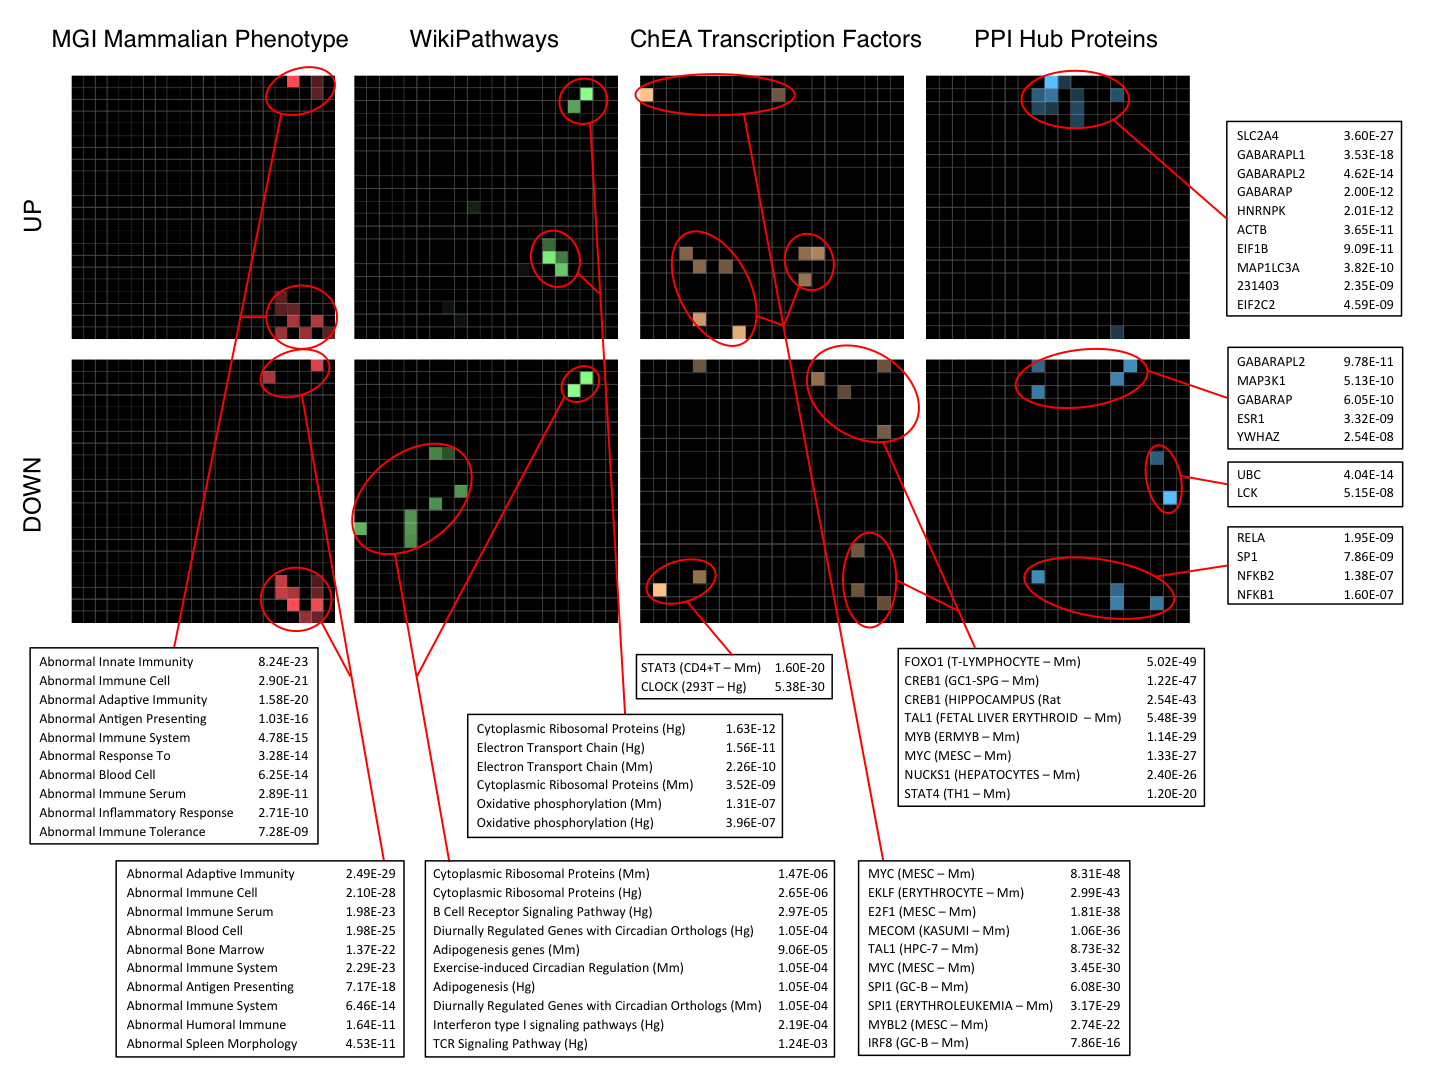

In [11]:
Image(filename='GATA1_spleen_canvases.png', width=1100, height=800)

#### Phenotypes
Nearly all of the top-ten enrichment terms for up-regulated genes are related to abnormal immune system phenotypes. This includes enrichment for both innate and adaptive immunity abnormalities, as well as abnormal immune cells and blood cells. Highly enriched terms also include "abnormal antigen presenting", "abnormal immune serum",
"abnormal immune tolerance”, and “abnormal inflammatory response”.

Among down-regulated genes, we first note that the phenotype for "abnormal spleen physiology“ is enriched, providing a level of confidence in the enrichment results. Abnormal blood cells and immune cells were also highly ranked. Notably, many of these same terms were significantly enriched in bone marrow as well. Together, these terms imply that the GATA1 plays an important role in the ability of immune system to function normally.


#### Pathways
Among Wikipathways terms, we saw enrichment for cytoplasmic ribosomal proteins among both up- and down-regulated genes. These terms were also significantly enriched in bone marrow. Genes related to the oxidative phosphorylation and the electron transport chain were also up-regulated; these processes are crucial for the generation of ATP. Adipogenesis was a process also enriched among down-regulated genes. Such gene expression regulates the storage of energy reserves in body fat.

Notably, genes involved in the circadian system appeared to be down-regulated. Exercise-induced circadian regulation and diurnally-related genes with circadian orthologs were significantly enriched among down-regulated genes. There is evidence that in rodent models, circadian clock genes are central to the function of metabolic organs and adipose tissue.


#### Transcription Factors
Firstly, we note that there is a very high degree of overlap between the transcription factors enriched in spleen and those enriched in bone marrow of GATA1-knockouts. Notably, transcription factors SPI1 and EKLF are strongly enriched among up-regulated genes, a finding which concurs with enrichment findings in bone marrow. Proto-oncogenic trnscription factors MYC and MYB are also enriched among both up- and down-regulated genes. These transcription factors were also implicated in bone marrow samples of GATA1-knockout mice, and are known to play roles in hematopoiesis. We also found enrichment for transcription factors TAL1 and MECOM (also enriched in bone marrow). MECOM may play a role in apoptosis via TGF-beta, while TAL1 is a positive regulator of erythroid differentiation and hematopoeis. We also found additional support for a role of STAT3 and STAT4 (also enriched in bone marrow) in response to GATA1 ablation.

Several transcription factors, including CLOCK, CREB1, and FOXO1, were enriched in spleen but not in bone marrow. Both CREB1 and CLOCK play a role in regulating the sychonization of circadian rythm in adipose tissues. In particular, CLOCK functions as an essential regulator of circadian pacing. Mutations in CLOCK are associated with insomnia, weight gain, and depression. Along with pathway enrichment results, the implication of these two transcription factors suggests that knockout of GATA1 may results in changes the regulation of circadian rythm.


#### Hub Proteins
There also appeared to be relatively strong consensus between PPI enrichment results in spleen and those for bone marrow. As with bone marrow, the most highly enrichmed protein was SLC2A4, which is involved in glucose transport in response to insulin. We again saw enrichment for ACTB and EIF1B among up-regualted genes. ACTB encodes non-muscular, cytoskeletal actin and plays a central role in cell motility in eukaryotic cells. EIF1B, a translation initiation factor that may be involved in translation and RNA transport, is also strongly enriched in both spleen and blood marrow, but little else is known about its funciton. Enrichment for SLC2A4, ACTB, and EIF1B in among up-regulated genes in both spleen and bone marrow knockouts provides strong evidence that these proteins are activated by genes up-regulated in response to GATA1 ablation.

The GABARAP proteins are also highly enriched in both up- and down-regulated genes. This family of receptors are ligand-gated chloride channels involved in inhibitory neurotransmission. The polyubiquitin precursor UBC was also highly enriched in spleen but not bone marrow. Ubiquitin is associated with multiple cellular processes, including protein degredation, DNA repair, and cell cycle. Ubiquitination of Lys-630-linked is involved in activation of transciption factor NF-kappa-B. Notably, NFKB1 and NFKB2 were enriched among down-regulated genes, and are central to the NF-kappa-B protein complex. This complex is involved in many celllular processes, and constitutive activation of NF-kappa-B is found in many cancers. 


### L1000CDS2 Analysis

We submitted the up- and down-regulated gene lists to L1000CDS2. This tool searches through the LINCS L1000 data for small-molecule gene signatures that may reverse or mimic your input signature, allowing us to compare the GATA1-knockout characteristic direction (CD) differential expression signature with the CD signatures of nearly 4,000 small-molecules. This is done by computing the signatures with the greatest (reverse) or least (mimic) cosine distance between the CD signature vectors. A full description of the method can be found on the [_help page_](http://amp.pharm.mssm.edu/L1000CDS2/help/), and you can browse the full results on the site:

* [_Small Molecules that REVERSE the GATA1-KO Signature_](http://amp.pharm.mssm.edu/L1000CDS2/#/result/57e307b84760621c0177d881)
* [_Small Molecules that MIMIC the GATA1-KO Signature_](http://amp.pharm.mssm.edu/L1000CDS2/#/result/57e307da4760621c0177d883)

In [12]:
# Get L1000CDS2 Results
for dirn in ['mimic','reverse']:
    cds2_df = pd.read_table('GATA1_spleen_L1000CDS2_'+dirn+'.txt', index_col=0)
    print "Small Molecules that",dirn.upper(),"the GATA1-KO Spleen Signature"
    cols = cds2_df.columns.values.tolist()
    cols.remove('Perturbation PubChem URL')
    cols.append('Perturbation PubChem URL')
    del cds2_df.index.name
    cds2_df = cds2_df.ix[:,cols]
    display(cds2_df.drop(['Perturbation LIFE URL',
                             'Signature URL',
                             'Perturbation DrugBank URL'],axis=1).head(15))


Small Molecules that MIMIC the GATA1-KO Spleen Signature


,1-cos(α),Perturbation,Cell-line,Dose,Time,Perturbation PubChem URL
1,0.7112,NCGC00182615-01,A375,10.0um,6.0h,http://pubchem.ncbi.nlm.nih.gov/summary/summary.cgi?cid=44142155
2,0.7150,TRIMEPRAZINE TARTRATE,A549,10.0um,24.0h,http://pubchem.ncbi.nlm.nih.gov/summary/summary.cgi?cid=5702128
3,0.7296,BRD-A93206962,MCF7,10.0um,24.0h,http://pubchem.ncbi.nlm.nih.gov/summary/summary.cgi?cid=19385000
4,0.7312,NCGC00242553-01,A375,10.0um,6.0h,http://pubchem.ncbi.nlm.nih.gov/summary/summary.cgi?cid=60138128
5,0.7318,VU0415556-1,A375,10.0um,6.0h,http://pubchem.ncbi.nlm.nih.gov/summary/summary.cgi?cid=45489448
6,0.7336,TGX-221,HS578T,0.12um,24h,http://pubchem.ncbi.nlm.nih.gov/summary/summary.cgi?cid=9907093
7,0.7349,13224,A375,10.0um,6.0h,http://pubchem.ncbi.nlm.nih.gov/summary/summary.cgi?cid=16112820
8,0.7403,BRD-A39969961,NPC,10.0um,24.0h,http://pubchem.ncbi.nlm.nih.gov/summary/summary.cgi?cid=21865526
9,0.7412,BRD-K35133769,HCC515,10.0um,6.0h,http://pubchem.ncbi.nlm.nih.gov/summary/summary.cgi?cid=44460112
10,0.7415,UNC0638,MCF7,0.12um,24h,None


Small Molecules that REVERSE the GATA1-KO Spleen Signature


,1-cos(α),Perturbation,Cell-line,Dose,Time,Perturbation PubChem URL
1,1.3534,S1104,PC3,10.0um,24.0h,http://pubchem.ncbi.nlm.nih.gov/summary/summary.cgi?cid=11717001
2,1.3486,WYE-125132,HS578T,10um,3h,http://pubchem.ncbi.nlm.nih.gov/summary/summary.cgi?cid=25260757
3,1.3232,SYK-inhibitor,HEPG2,10um,24h,http://pubchem.ncbi.nlm.nih.gov/summary/summary.cgi?cid=10200390
4,1.3207,GSK-1070916,HEPG2,0.37um,24h,http://pubchem.ncbi.nlm.nih.gov/summary/summary.cgi?cid=46885626
5,1.3195,A443654,HEPG2,0.12um,24h,None
6,1.3187,EBT or (Erichrome Black T),HCC515,10.0um,24.0h,http://pubchem.ncbi.nlm.nih.gov/summary/summary.cgi?cid=5473474
7,1.3166,EI-346,PC3,10.0um,24.0h,None
8,1.3166,WYE-125132,HME1,0.37um,3h,http://pubchem.ncbi.nlm.nih.gov/summary/summary.cgi?cid=25260757
9,1.3113,HY-10342,PC3,10.0um,24.0h,http://pubchem.ncbi.nlm.nih.gov/summary/summary.cgi?cid=176167
10,1.3104,PNU 74654,A549,80.0um,6.0h,http://pubchem.ncbi.nlm.nih.gov/summary/summary.cgi?cid=9836739


## Conclusions
Differential gene expression in GATA1-knockout mouse spleen confirm the involvement of many pathways and transciption factors which were identified in the bone marrow analysis. Most notably, we see a confirmation of irregular immune system funcitoning and abnomrmal immune cells observed in bone marrow. Additionally, the activation of the MYB, MYC, MECOM, TAL1, STAT2, and STAT3 transcription factors appears to occur in both spleen and bone marrow following the knockout of GATA1. According to both bone marrow and spleen analysis, the SLC4A1, ACTB, and EIF1B proteins are all likely to be targeted by genes upregulated in the absence of GATA1. The most notable difference in enrichment results for spleen was the role of circadian rythmicity. Both pathway enrichment as well as transciption factor enrichment results in spleen point to the dysregulation of these process in adipocytes. Additionally, it appears that the NF-kappa-B pathway is being targeted in spleen, but not in bone marrow.